**THƯ VIỆN**

In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

**ĐỌC VÀ XỬ LÍ DỮ LIỆU**

In [162]:
# 1. Đọc dữ liệu
df = pd.read_csv("NBT orders data.csv")
df.columns = [c.strip().replace(" ", "_").replace("/", "_") for c in df.columns]


In [163]:
# 2. Target numeric (Hiệu suất chuyền %)
df["Hiệu_suất_chuyền"] = pd.to_numeric(
    df["Hiệu_suất_chuyền"].replace(" - ", np.nan),
    errors="coerce"
)
df = df.dropna(subset=["Hiệu_suất_chuyền"]).reset_index(drop=True)

In [164]:
# 3. Encode categorical
categorical_cols = ["Độ_trơn_bề_mặt_vải", "Độ_co_giãn_của_vải", "Bố_trí_&_cân_bằng_chuyền"]
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

In [165]:
# 4. Xử lý numeric (%)
df["Tỷ_lệ_máy_phù_hợp_(%)"] = df["Tỷ_lệ_máy_phù_hợp_(%)"].astype(float)

**TRỰC QUAN & THĂM DÒ DỮ LIỆU**

In [166]:
# 5. kiểm tra dữ liệu
print(df.info())
print(df.describe(include="all"))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   STT                       150 non-null    object 
 1   Số_lượng                  150 non-null    int64  
 2   Số_màu_đơn_hàng           150 non-null    int64  
 3   GSM_(g_m²)                150 non-null    int64  
 4   Độ_trơn_bề_mặt_vải        150 non-null    int64  
 5   Độ_co_giãn_của_vải        150 non-null    int64  
 6   SMV_(phút_pc)             150 non-null    float64
 7   Lao_động_trực_tiếp        150 non-null    int64  
 8   Bậc_thợ_TB                150 non-null    int64  
 9   Bố_trí_&_cân_bằng_chuyền  150 non-null    int64  
 10  Tỷ_lệ_máy_phù_hợp_(%)     150 non-null    float64
 11  Hiệu_suất_chuyền          150 non-null    float64
dtypes: float64(3), int64(8), object(1)
memory usage: 14.2+ KB
None
               STT      Số_lượng  Số_màu_đơn_hàng  GSM_(g

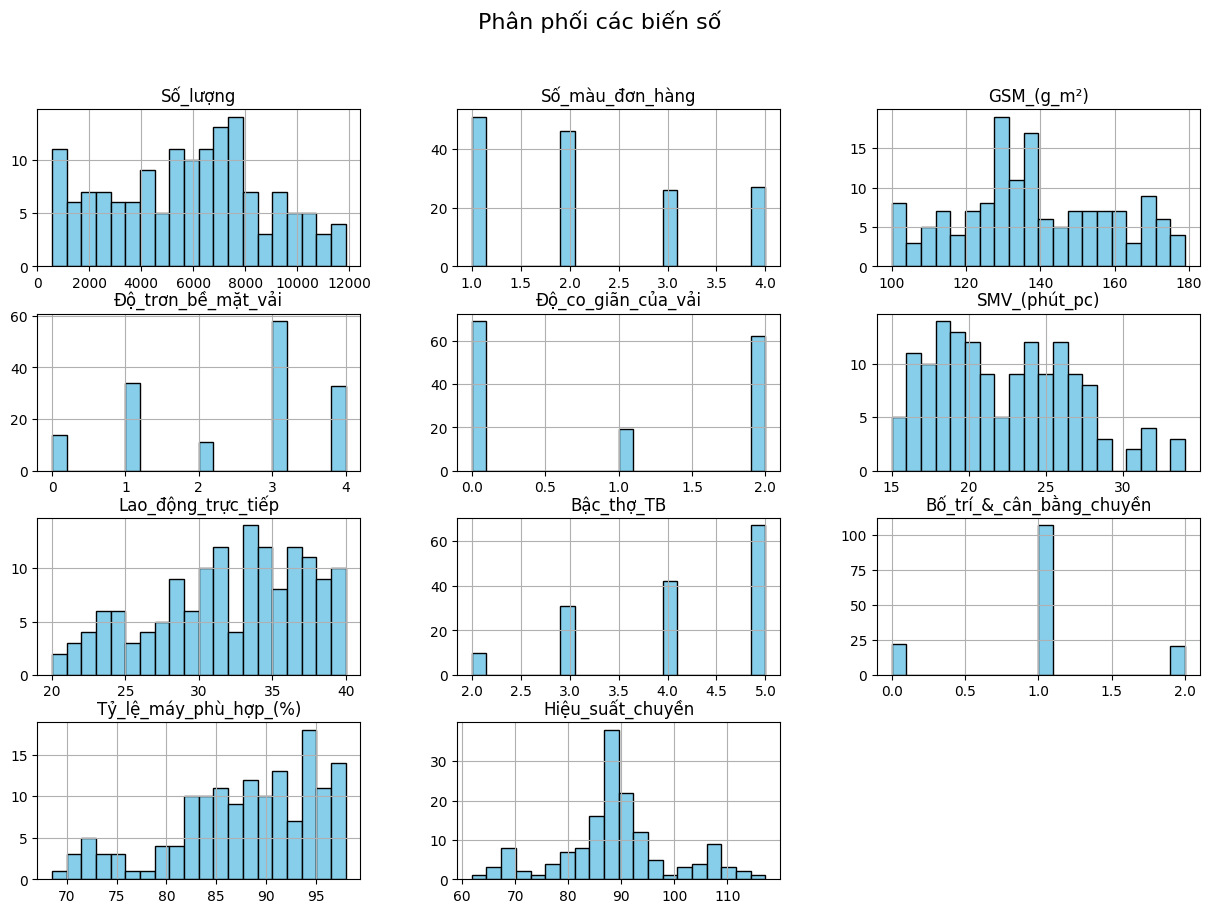

In [167]:
# --- 6. Phân phối biến số ---
num_cols = df.select_dtypes(include=["int64", "float64"]).columns
df[num_cols].hist(bins=20, figsize=(15, 10), color="skyblue", edgecolor="black")
plt.suptitle("Phân phối các biến số", fontsize=16)
plt.show()

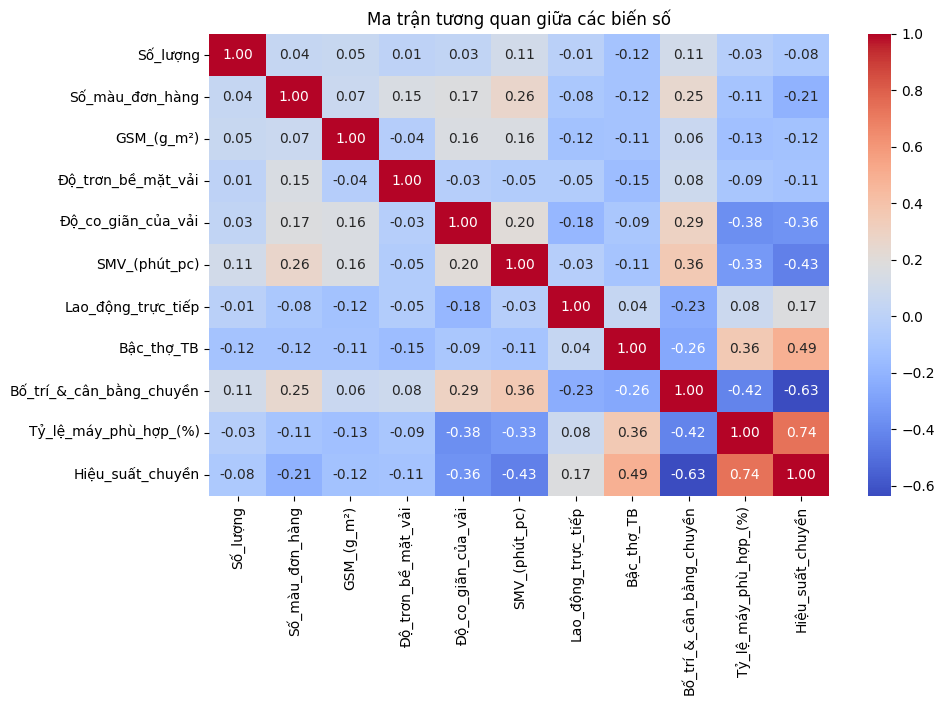

In [168]:
# --- 7. Ma trận tương quan ---
plt.figure(figsize=(10, 6))
corr = df[num_cols].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Ma trận tương quan giữa các biến số")
plt.show()


**TRAIN & TEST**

In [169]:
# 8. Input / Output
X = df[[
    "Số_lượng",
    "Số_màu_đơn_hàng",
    "GSM_(g_m²)",
    "Độ_trơn_bề_mặt_vải",
    "Độ_co_giãn_của_vải",
    "SMV_(phút_pc)",
    "Lao_động_trực_tiếp",
    "Bậc_thợ_TB",
    "Bố_trí_&_cân_bằng_chuyền",
    "Tỷ_lệ_máy_phù_hợp_(%)"
]]
y = df["Hiệu_suất_chuyền"]

In [170]:
# 9. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Scale numeric
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**MÔ HÌNH**

In [171]:
# 10. Define models
models = {
    "Random Forest": RandomForestRegressor(
        n_estimators=200, max_depth=10, min_samples_leaf=3, random_state=42
    ),
    "XGBoost": XGBRegressor(
        n_estimators=200, learning_rate=0.05, max_depth=5,
        subsample=0.8, colsample_bytree=0.8, random_state=42
    ),
    "Linear Regression": LinearRegression()
}

**KẾT QUẢ VÀ ĐÁNH GIÁ MÔ HÌNH**

In [172]:
# 11. Train & Evaluate
results = {}
predictions = {}

for name, model in models.items():
    # Với CatBoost và LightGBM thì không cần scale, nhưng để đồng nhất thì dùng scaled luôn
    model.fit(X_train_scaled, y_train)
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    predictions[name] = (y_train_pred, y_test_pred)

    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

    results[name] = {
        "Train_R²": r2_score(y_train, y_train_pred),
        "Test_R²": r2_score(y_test, y_test_pred),
        "Train_MAE(%)": mean_absolute_error(y_train, y_train_pred),
        "Test_MAE(%)": mean_absolute_error(y_test, y_test_pred),
        "Train_RMSE(%)": rmse_train,
        "Test_RMSE(%)": rmse_test
    }

results_df = pd.DataFrame(results).T
print("\n=== Model Evaluation (Hiệu suất chuyền %) ===")
print(results_df.round(3))



=== Model Evaluation (Hiệu suất chuyền %) ===
                   Train_R²  Test_R²  Train_MAE(%)  Test_MAE(%)  \
Random Forest         0.946    0.884         1.788        2.777   
XGBoost               0.999    0.874         0.184        2.870   
Linear Regression     0.709    0.729         4.465        4.584   

                   Train_RMSE(%)  Test_RMSE(%)  
Random Forest              2.457         3.664  
XGBoost                    0.263         3.817  
Linear Regression          5.699         5.597  


C:\Users\nhat2\AppData\Local\Temp\ipykernel_7064\2227763486.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y="Test_R²", data=results_df, ax=axes[0], palette="viridis")
C:\Users\nhat2\AppData\Local\Temp\ipykernel_7064\2227763486.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y="Test_MAE(%)", data=results_df, ax=axes[1], palette="magma")


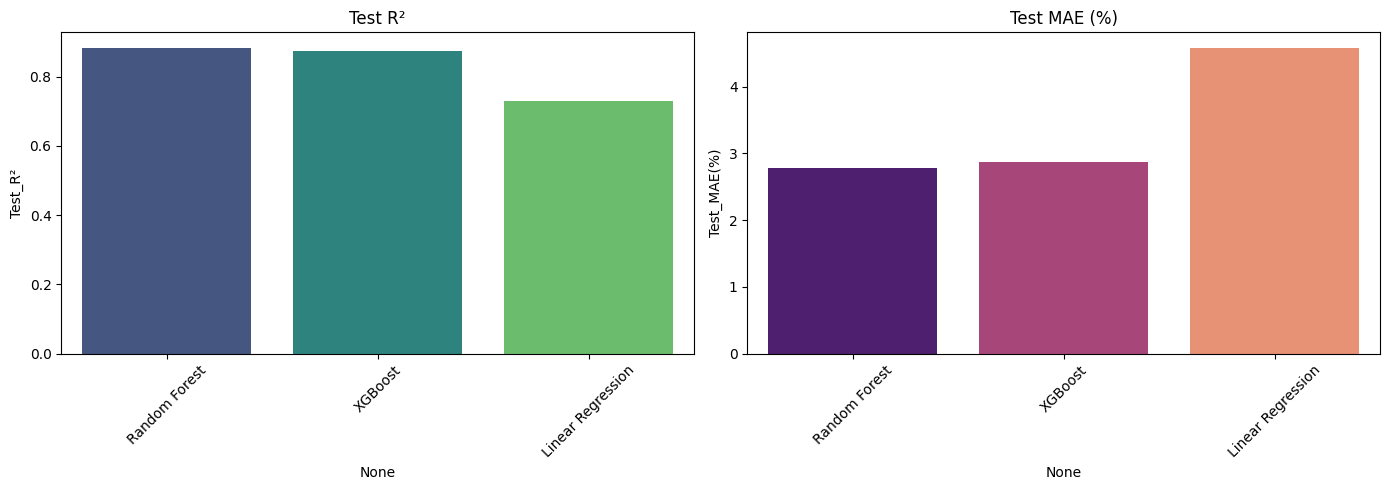

In [173]:
# 12. So sánh trực quan các mô hình (Test R² và MAE)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.barplot(x=results_df.index, y="Test_R²", data=results_df, ax=axes[0], palette="viridis")
axes[0].set_title("Test R²")
axes[0].tick_params(axis='x', rotation=45)

sns.barplot(x=results_df.index, y="Test_MAE(%)", data=results_df, ax=axes[1], palette="magma")
axes[1].set_title("Test MAE (%)")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

C:\Users\nhat2\AppData\Local\Temp\ipykernel_7064\1880631107.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=imp_df, palette="viridis")


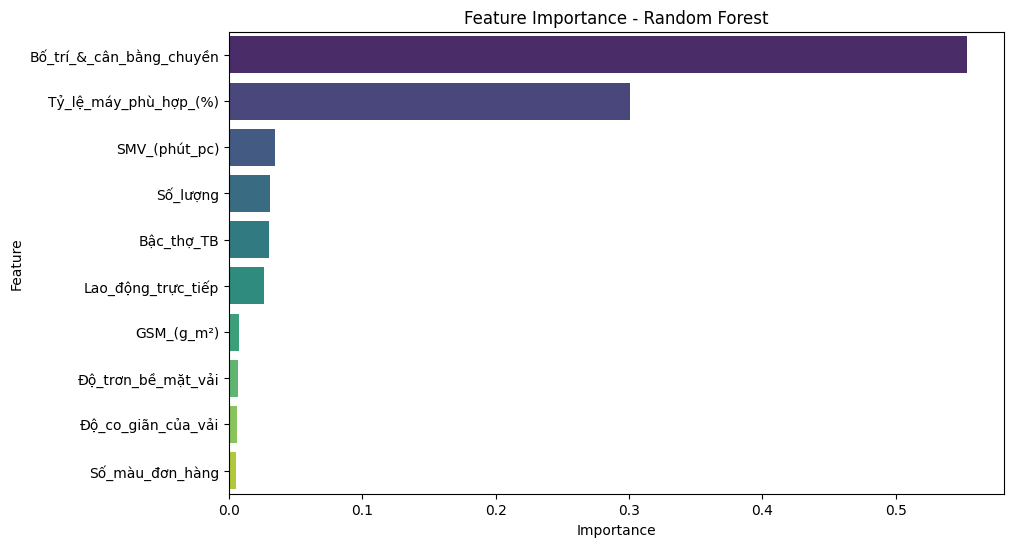

In [174]:
# 13. Feature importance - Random Forest
rf = models["Random Forest"]
importances = rf.feature_importances_
feat_names = X.columns

imp_df = pd.DataFrame({"Feature": feat_names, "Importance": importances})
imp_df = imp_df.sort_values("Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=imp_df, palette="viridis")
plt.title("Feature Importance - Random Forest")
plt.show()


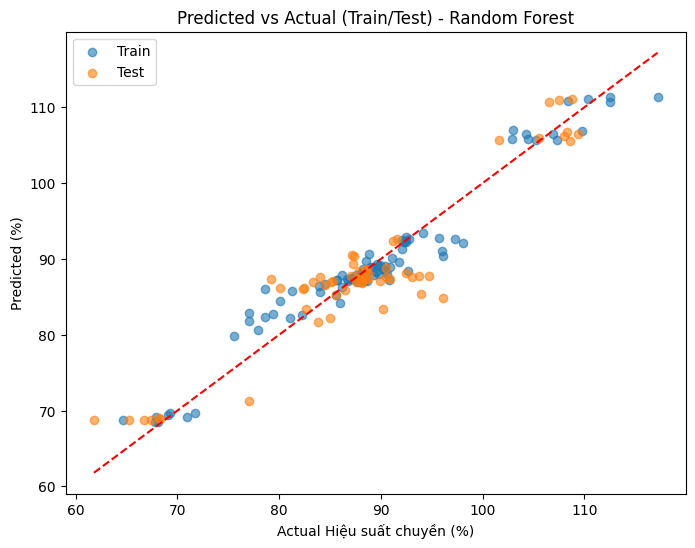

In [175]:
# 14. Predicted vs Actual (Test set - ví dụ Random Forest)
y_train_pred, y_test_pred = predictions["Random Forest"]

plt.figure(figsize=(8, 6))
plt.scatter(y_train, y_train_pred, label="Train", alpha=0.6)
plt.scatter(y_test, y_test_pred, label="Test", alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], "r--")
plt.xlabel("Actual Hiệu suất chuyền (%)")
plt.ylabel("Predicted (%)")
plt.title("Predicted vs Actual (Train/Test) - Random Forest")
plt.legend()
plt.show()
